In [56]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

import pandas as pd
import numpy as np

import tensorflow as tf 
from tensorflow import keras
from keras.layers import Flatten

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import os
import tempfile

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns




In [57]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [58]:
df = pd.read_csv("/Users/robbiefeldstein/Documents/Programming/Research/Datasets/group_May_22.csv")
df.head()


,Unnamed: 0,Coordinates,nearest_time,lightning,CMI_C01,CMI_C02,CMI_C03,CMI_C04,CMI_C05,CMI_C06,...,CMI_C15,CMI_C16,ACM,BCM,Cloud_Probabilities,lat,lon,time,time_int,Lightning
0,0,"(40.13103323474366, -93.38155072424266)",0,0.0,0.331051,0.283293,0.454821,0.001786,0.371012,0.296587,...,274.79310,263.45618,1.734227,0.734227,0.505974,40.131033,-93.381551,2022-05-21 19:00:31.268224,1653159631268224000,0
1,1,"(40.12698592712501, -93.2741436595977)",0,0.0,0.296647,0.242758,0.444345,0.001746,0.330734,0.259226,...,275.39243,263.77637,1.375754,0.500453,0.446567,40.126986,-93.274144,2022-05-21 19:00:31.268224,1653159631268224000,0
2,2,"(40.122965705716815, -93.16685328500078)",0,0.0,0.301825,0.247361,0.450753,0.001825,0.329881,0.260476,...,275.28073,263.76944,1.593902,0.593902,0.484379,40.122966,-93.166853,2022-05-21 19:00:31.268224,1653159631268224000,0
3,3,"(40.11897247748837, -93.05967862352706)",0,0.0,0.344345,0.293075,0.490972,0.002063,0.365119,0.283512,...,275.14670,263.74536,1.828127,0.828127,0.638011,40.118972,-93.059679,2022-05-21 19:00:31.268224,1653159631268224000,0
4,4,"(40.115006150366405, -92.95261870531907)",0,0.0,0.335952,0.285119,0.485000,0.002103,0.361805,0.283472,...,275.35516,263.82800,1.796349,0.811898,0.613374,40.115006,-92.952619,2022-05-21 19:00:31.268224,1653159631268224000,0


In [59]:
#Look at class imbalance

neg, pos = np.bincount(df['Lightning'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 468750
    Positive: 25562 (5.45% of total)



In [60]:
features = ["CMI_C01", "CMI_C02", "CMI_C03","CMI_C04", "CMI_C05","CMI_C06", "CMI_C07","CMI_C15","Cloud_Probabilities","Lightning"]
#let's just do less features
#Predictors

copy_df = df.copy()
copy_df = copy_df[features]

X = copy_df[features]

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(copy_df, test_size=0.3)
train_df, val_df = train_test_split(train_df, test_size=0.3)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Lightning'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Lightning'))
test_labels = np.array(test_df.pop('Lightning'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [61]:
#Averages are roughly similar

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0544
Average class probability in validation set: 0.0549
Average class probability in test set:       0.0544


In [62]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (229687,)
Validation labels shape: (98438,)
Test labels shape: (140625,)
Training features shape: (229687, 9)
Validation features shape: (98438, 9)
Test features shape: (140625, 9)


In [63]:
#Recommended parameters for imbalanced model

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
    keras.layers.Dense(len(features), activation='relu', input_shape=(train_features.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dropout(0.5),
    #Output layer
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
])

  model.compile(
      optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.Precision()])

  return model

In [64]:
EPOCHS = 128
BATCH_SIZE = 16384

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [65]:
initial_bias = np.log([pos/len(df)])
print(initial_bias)
model = make_model(output_bias=initial_bias)
model.summary()

[-2.9089627]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 10)                100       
                                                                 
 batch_normalization_6 (Bat  (None, 10)                40        
 chNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 16)                176       
                                                                 
 dropout_24 (Dropout)        (None, 16)                0         
                                                                 
 dense_38 (Dense)            (None, 8)                 136       
                                                                 
 dropout_25 (Dropout)        (None, 8)                 0         
                                         

In [66]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [67]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

2023-11-14 15:24:12.589721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loss: 0.2558


2023-11-14 15:24:14.787992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 312ms/step


array([[4.4899383e-03],
       [1.1355537e-01],
       [2.5141600e-01],
       [4.6908468e-04],
       [8.6929533e-04],
       [6.8165445e-01],
       [9.6954399e-01],
       [4.6863263e-03],
       [4.6336444e-04],
       [1.8483832e-02]], dtype=float32)

In [68]:
# model = make_model()
# model.load_weights(initial_weights)
# model.layers[-1].bias.assign([0.0])
# zero_bias_history = model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     epochs=16,
#     validation_data=(val_features, val_labels), 
#     verbose=0)

In [69]:
# model = make_model()
# model.load_weights(initial_weights)
# careful_bias_history = model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     epochs=16,
#     validation_data=(val_features, val_labels), 
#     verbose=0)

In [70]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [71]:
# plot_loss(zero_bias_history, "Zero Bias", 0)
# plot_loss(careful_bias_history, "Careful Bias", 1)

In [72]:
def plot_metrics(history):
  metrics = ['loss', 'precision',]
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [73]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

9/9 [==============================] - 0s 16ms/step


In [74]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [75]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 9.17


In [76]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)
EPOCHS = 250
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight,
    verbose=1)

Epoch 1/250


2023-11-14 15:24:15.884684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 2.1058 - precision_8: 0.0649

2023-11-14 15:24:23.694169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 10s 396ms/step - loss: 2.1058 - precision_8: 0.0649 - val_loss: 0.2008 - val_precision_8: 0.0000e+00
Epoch 2/250
15/15 [==============================] - 0s 21ms/step - loss: 1.8750 - precision_8: 0.0777 - val_loss: 0.1851 - val_precision_8: 0.0000e+00
Epoch 3/250
15/15 [==============================] - 0s 18ms/step - loss: 1.7557 - precision_8: 0.0865 - val_loss: 0.1866 - val_precision_8: 0.0000e+00
Epoch 4/250
15/15 [==============================] - 0s 18ms/step - loss: 1.7310 - precision_8: 0.0914 - val_loss: 0.1917 - val_precision_8: 0.6667
Epoch 5/250
15/15 [==============================] - 0s 17ms/step - loss: 1.6703 - precision_8: 0.0966 - val_loss: 0.1963 - val_precision_8: 0.5578
Epoch 6/250
15/15 [==============================] - 0s 18ms/step - loss: 1.6136 - precision_8: 0.1005 - val_loss: 0.2051 - val_precision_8: 0.4118
Epoch 7/250
15/15 [==============================] - 0s 18ms/step - loss: 1.5937 - precision_8: 0.1025 - val_l

In [77]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

2023-11-14 15:25:32.190814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 17ms/step


9/9 [==============================] - 0s 8ms/step - loss: 0.5105 - precision_8: 0.1462
loss :  0.510508120059967
precision_8 :  0.14622555673122406

Legitimate Transactions Detected (True Negatives):  126814
Legitimate Transactions Incorrectly Detected (False Positives):  6159
Fraudulent Transactions Missed (False Negatives):  6434
Fraudulent Transactions Detected (True Positives):  1218
Total Fraudulent Transactions:  7652


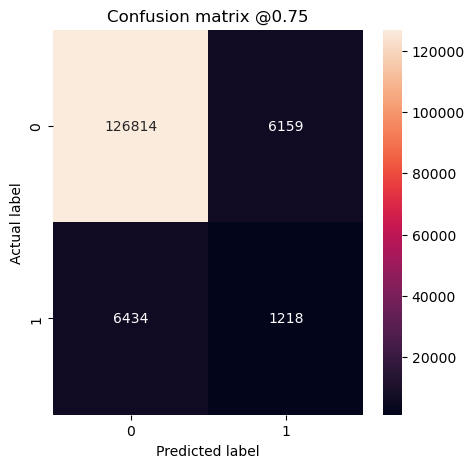

In [79]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=1)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted,threshold=0.75)